In [14]:
# -*- coding: utf-8 -*-

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
from imageio import imread, imsave, mimsave
import glob
from tqdm import tqdm

In [ ]:
images = glob.glob('faces/*.jpg')
print(len(images))

In [ ]:
# 特征标签
tags = pd.read_csv('face_tags.txt')
tags.index = tags['id']
tags.head()

### params

In [ ]:
batch_size = 64
z_dim = 128
WIDTH = 128
HEIGHT = 128
LABEL = 34
LAMBDA = 0.05
BETA = 3  # 增加特征分类损失的权重

OUTPUT_DIR = 'samples'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [ ]:
X = tf.placeholder(dtype=tf.float32,
                   shape=[batch_size, HEIGHT, WIDTH, 3],
                   name='X')
# 对X真实样本增加随机的小范围扰动
X_perturb = tf.placeholder(dtype=tf.float32,
                           shape=[batch_size, HEIGHT, WIDTH, 3],
                           name='X_perturb')
Y = tf.placeholder(dtype=tf.float32, shape=[batch_size, LABEL], name='Y')

# 生成器输入
noise = tf.placeholder(dtype=tf.float32,
                       shape=[batch_size, z_dim],
                       name='noise')
# 生成器输入随机label特征，让生成器训练
noise_y = tf.placeholder(dtype=tf.float32,
                         shape=[batch_size, LABEL],
                         name='noise_y')

is_training = tf.placeholder(dtype=tf.bool, name='is_training')

global_step = tf.Variable(0, trainable=False)
add_global = global_step.assign_add(1)
initial_learning_rate = 0.0002
learning_rate = tf.train.exponential_decay(initial_learning_rate,
                                           global_step=global_step,
                                           decay_steps=20000,
                                           decay_rate=0.5)

### Layer

In [ ]:
def lrelu(x, leak=0.2):
    return tf.maximum(x, leak * x)


def sigmoid_cross_entropy_with_logits(x, y):
    return tf.nn.sigmoid_cross_entropy_with_logits(logits=x, labels=y)


def conv2d(inputs,
           kernel_size,
           filters,
           strides,
           padding='same',
           use_bias=True):
    return tf.layers.conv2d(inputs=inputs,
                            kernel_size=kernel_size,
                            filters=filters,
                            strides=strides,
                            padding=padding,
                            use_bias=use_bias)


def batch_norm(inputs, is_training=is_training, decay=0.9):
    return tf.contrib.layers.batch_norm(inputs,
                                        is_training=is_training,
                                        decay=decay)

### discriminator
https://arxiv.org/abs/1708.05509

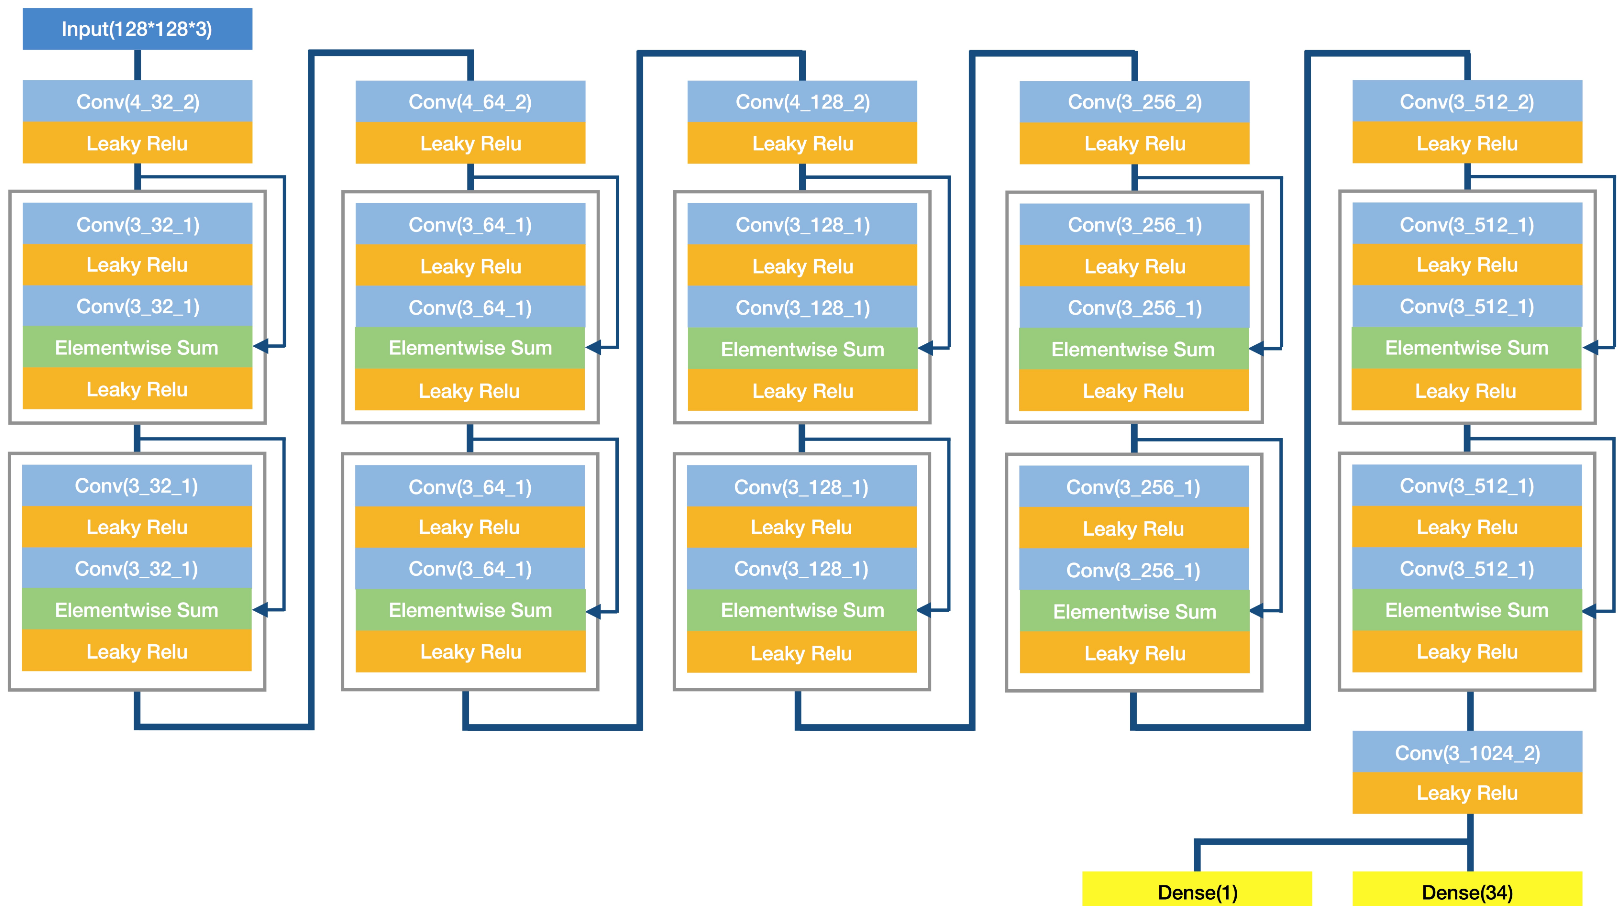

In [ ]:
def d_block(inputs, filters):
    """判别器基本单元
    return--h0为真假判别；Y_为特征标签判别结果
    """
    h0 = lrelu(conv2d(inputs, 3, filters, 1))
    h0 = conv2d(h0, 3, filters, 1)
    h0 = lrelu(tf.add(h0, inputs))
    return h0

def discriminator(image, reuse=None):
    with tf.variable_scope('discriminator', reuse=reuse):
        h0 = image
        
        f = 32
        for i in range(5):
            if i < 3:
                h0 = lrelu(conv2d(h0, 4, f, 2))
            else:
                h0 = lrelu(conv2d(h0, 3, f, 2))
            h0 = d_block(h0, f)
            h0 = d_block(h0, f)
            f = f * 2
        
        h0 = lrelu(conv2d(h0, 3, f, 2))
        h0 = tf.contrib.layers.flatten(h0)
        Y_ = tf.layers.dense(h0, units=LABEL)
        h0 = tf.layers.dense(h0, units=1)
        return h0, Y_

### generator
https://arxiv.org/abs/1708.05509

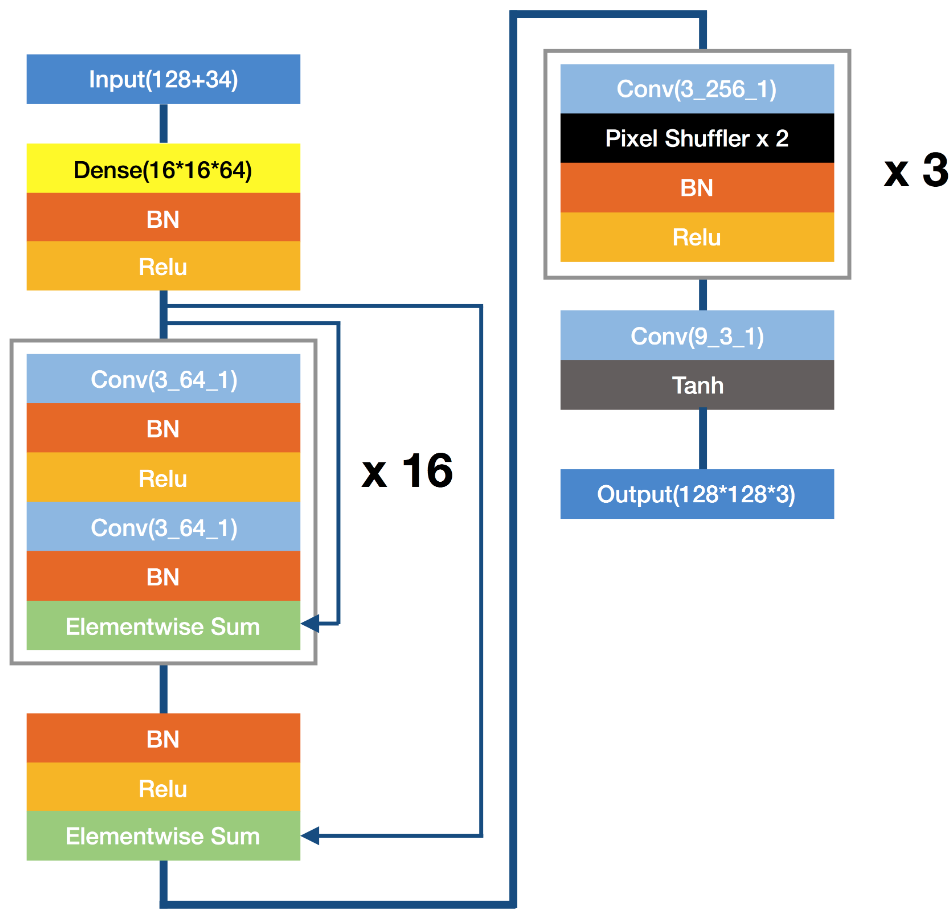

Sub-pixel CNN代替deconvolution
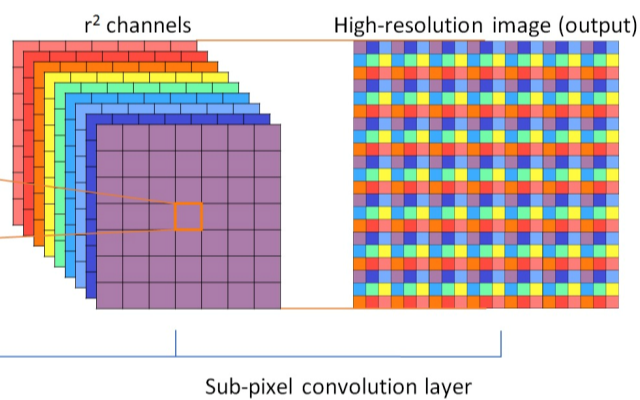

In [ ]:
def g_block(inputs):
    """生成器单元"""
    # use_bias=True会降低模型效果
    h0 = tf.nn.relu(batch_norm(conv2d(inputs, 3, 64, 1, use_bias=False)))
    h0 = batch_norm(conv2d(h0, 3, 64, 1, use_bias=False))
    h0 = tf.add(h0, inputs)
    return h0

def generator(z, label):
    with tf.variable_scope('generator', reuse=None):
        d = 16
        z = tf.concat([z, label], axis=1)
        h0 = tf.layers.dense(z, units=d * d * 64)
        h0 = tf.reshape(h0, shape=[-1, d, d, 64])
        h0 = tf.nn.relu(batch_norm(h0))
        shortcut = h0
        
        for i in range(16):
            h0 = g_block(h0)
            
        h0 = tf.nn.relu(batch_norm(h0))
        h0 = tf.add(h0, shortcut)
        
        for i in range(3):
            h0 = conv2d(h0, 3, 256, 1, use_bias=False)
            # Sub-pixel CNN：将不同通道同一位置的pixel，转化为一个feature map上的pixel
            h0 = tf.depth_to_space(h0, 2)
            h0 = tf.nn.relu(batch_norm(h0))
        
        h0 = tf.layers.conv2d(h0, kernel_size=9, filters=3, strides=1, padding='same', activation=tf.nn.tanh, name='g', use_bias=True)
        return h0

### graph

In [ ]:
g = generator(noise, noise_y)
d_real, y_real = discriminator(X)
d_fake, y_fake = discriminator(g, reuse=True)

loss_d_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_real, tf.ones_like(d_real)))
loss_d_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.zeros_like(d_fake)))
loss_g_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(d_fake, tf.ones_like(d_fake)))

# 注意，使用了noise_y，而没有用Y
loss_c_real = tf.reduce_mean(sigmoid_cross_entropy_with_logits(y_real, Y))
loss_c_fake = tf.reduce_mean(sigmoid_cross_entropy_with_logits(y_fake, noise_y))

loss_d = loss_d_real + loss_d_fake + BETA * loss_c_real
loss_g = loss_g_fake + BETA * loss_c_fake

# gradient penalty
alpha = tf.random_uniform(shape=[batch_size, 1, 1, 1], minval=0., maxval=1.)
# 不同于原始WGAN，这里采用真实样本和干扰样本的插值
interpolates = alpha * X + (1 - alpha) * X_perturb
grad = tf.gradients(discriminator(interpolates, reuse=True)[0], [interpolates])[0]
slop = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1]))
gp = tf.reduce_mean((slop - 1.) ** 2)
loss_d += LAMBDA * gp

In [ ]:
# 分别建立生成器和判别器的BP计算路径
vars_g = [var for var in tf.trainable_variables() if var.name.startswith('generator')]
vars_d = [var for var in tf.trainable_variables() if var.name.startswith('discriminator')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer_d = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(loss_d, var_list=vars_d)
    optimizer_g = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.5).minimize(loss_g, var_list=vars_g)

### utils

In [16]:
def montage(images):
    """绘图函数"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    if len(images.shape) == 4 and images.shape[3] == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 3)) * 0.5
    elif len(images.shape) == 4 and images.shape[3] == 1:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1, 1)) * 0.5
    elif len(images.shape) == 3:
        m = np.ones(
            (images.shape[1] * n_plots + n_plots + 1,
             images.shape[2] * n_plots + n_plots + 1)) * 0.5
    else:
        raise ValueError('Could not parse image shape of {}'.format(images.shape))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                m[1 + i + i * img_h:1 + i + (i + 1) * img_h,
                  1 + j + j * img_w:1 + j + (j + 1) * img_w] = this_img
    return m

In [ ]:
# 输入处理
X_all = []
Y_all = []
for i in tqdm(range(len(images))):
    image = imread(images[i])
    image = (image / 255. - 0.5) * 2
    X_all.append(image)
    
    y = list(tags.loc[images[i]])
    Y_all.append(y[1:])

X_all = np.array(X_all)
Y_all = np.array(Y_all)
print(X_all.shape, Y_all.shape)

In [ ]:
def get_random_tags():
    """生成随机的标签，输入到生成器"""
    y = np.random.uniform(0.0, 1.0, [batch_size, LABEL]).astype(np.float32)
    y[y > 0.75] = 1
    y[y <= 0.75] = 0
    
    for i in range(batch_size):
        hc = np.random.randint(0, 13)
        hs = np.random.randint(13, 18)
        ec = np.random.randint(18, 28)
        
        y[i, :28] = 0
        y[i, hc] = 1 # hair color
        y[i, hs] = 1 # hair style
        y[i, ec] = 1 # eye color
    
    return y

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#####################################
# 测试过程的生成器输入
z_samples = np.random.uniform(-1.0, 1.0,
                              [batch_size, z_dim]).astype(np.float32)
y_samples = get_random_tags()

for i in range(batch_size):
    # 生成固定格式特征排列的图像
    y_samples[i, :28] = 0
    y_samples[i, i // 8 % 13] = 1  # hair color
    y_samples[i, i // 8 % 5 + 13] = 1  # hair style
    y_samples[i, i // 8 % 10 + 18] = 1  # eye color

samples = []  # 生成的图片储存list
loss = {'d': [], 'g': []}

#####################################
# 训练
offset = 0
for i in tqdm(range(60000)):
    if offset + batch_size > X_all.shape[0]:
        offset = 0
    
    if offset == 0:  # 再shuffle
        data_index = np.arange(X_all.shape[0])
        np.random.shuffle(data_index)
        X_all = X_all[data_index, :, :, :]
        Y_all = Y_all[data_index, :]
    
    # batch处理
    X_batch = X_all[offset:offset + batch_size, :, :, :]
    Y_batch = Y_all[offset:offset + batch_size, :]
    X_batch_perturb = X_batch + 0.5 * X_batch.std() * np.random.random(
        X_batch.shape)
    
    # 生成器noise
    n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
    # 生成器label noise
    ny = get_random_tags()
    
     offset += batch_size
    
    # 训练D
    _, d_ls = sess.run(
        [optimizer_d, loss_d],
        feed_dict={
            X: X_batch,
            X_perturb: X_batch_perturb,
            Y: Y_batch,
            noise: n,
            noise_y: ny,
            is_training: True
        })
    
    # 训练G
    n = np.random.uniform(-1.0, 1.0, [batch_size, z_dim]).astype(np.float32)
    ny = get_random_tags()
    _, g_ls = sess.run([optimizer_g, loss_g],
                       feed_dict={
                           noise: n,
                           noise_y: ny,
                           is_training: True
                       })
    
    loss['d'].append(d_ls)
    loss['g'].append(g_ls)

    _, lr = sess.run([add_global, learning_rate])

    # 测试训练结果
    if i % 500 == 0:
        print(i, d_ls, g_ls, lr)
        gen_imgs = sess.run(g,
                            feed_dict={
                                noise: z_samples,
                                noise_y: y_samples,
                                is_training: False
                            })
        gen_imgs = (gen_imgs + 1) / 2
        imgs = [img[:, :, :] for img in gen_imgs]
        
        gen_imgs = montage(imgs)
        plt.axis('off')
        plt.imshow(gen_imgs)
        imsave(os.path.join(OUTPUT_DIR, 'sample_%d.jpg' % i), gen_imgs)
        plt.show()
        samples.append(gen_imgs)

saver = tf.train.Saver()
saver.save(sess, './anime_acgan', global_step=60000)
        
plt.plot(loss['d'], label='Discriminator')
plt.plot(loss['g'], label='Generator')
plt.legend(loc='upper right')
plt.savefig('Loss.png')
plt.show()
mimsave(os.path.join(OUTPUT_DIR, 'samples.gif'), samples, fps=10)

### test

In [15]:
batch_size = 64
z_dim = 128
LABEL = 34

In [17]:
def get_random_tags():
    """根据数据集中数据分布规律，生成图像"""
    y = np.random.uniform(0.0, 1.0, [batch_size, LABEL]).astype(np.float32)
    
    # blush, smile, open mouth, hat, ribbon, glasses属性在数据集中的分布
    p_other = [0.6, 0.6, 0.25, 0.04488882, 0.3, 0.05384738]
    for i in range(batch_size):
        for j in range(len(p_other)):
            if y[i, j + 28] < p_other[j]:
                y[i, j + 28] = 1
            else:
                y[i, j + 28] = 0
                
    # 各类标签的数据分布
    # hair color
    phc = [0.15968645, 0.21305391, 0.15491921, 0.10523116, 0.07953927, 0.09508879, 0.03567429, 0.07733163, 0.03157895, 0.01833307, 0.02236442, 0.00537514, 0.00182371]
    # hair style
    phs = [0.52989922,  0.37101264,  0.12567589,  0.00291153,  0.00847864]
    # eye color
    pec = [0.28350664, 0.15760678, 0.17862742, 0.13412254, 0.14212126, 0.0543913, 0.01020637, 0.00617501, 0.03167493, 0.00156775]
    
    for i in range(batch_size):
        # 根在【0，1】区间上的分布，随机抽样
        y[i, :28] = 0

        hc = np.random.random()
        for j in range(len(phc)):
            if np.sum(phc[:j]) < hc < np.sum(phc[:j + 1]):
                y[i, j] = 1
                break

        hs = np.random.random()
        for j in range(len(phs)):
            if np.sum(phs[:j]) < hs < np.sum(phs[:j + 1]):
                y[i, j + 13] = 1
                break

        ec = np.random.random()
        for j in range(len(pec)):
            if np.sum(pec[:j]) < ec < np.sum(pec[:j + 1]):
                y[i, j + 18] = 1
                break
    return y

#### restore

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

saver = tf.train.import_meta_graph('./anime_acgan-60000.meta')
saver.restore(sess, tf.train.latest_checkpoint('./'))

graph = tf.get_default_graph()
g = graph.get_tensor_by_name('generator/g/Tanh:0')
noise = graph.get_tensor_by_name('noise:0')
noise_y = graph.get_tensor_by_name('noise_y:0')

is_training = graph.get_tensor_by_name('is_training:0')


# 随机生成样本
z_samples = np.random.uniform(-1.0, 1.0,
                              [batch_size, z_dim]).astype(np.float32)
y_samples = get_random_tags()

gen_imgs = sess.run(g,
                    feed_dict={
                        noise: z_samples,
                        noise_y: y_samples,
                        is_training: False
                    })

gen_imgs = (gen_imgs + 1) / 2
imgs = [img[:, :, :] for img in gen_imgs]
gen_imgs = montage(imgs)

gen_imgs = np.clip(gen_imgs, 0, 1)

imsave('test_1.jpg', gen_imgs)

INFO:tensorflow:Restoring parameters from ./anime_acgan-60000


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


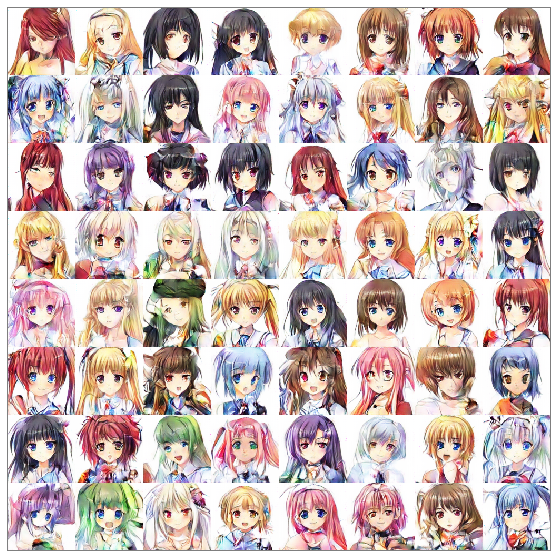

In [20]:
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(gen_imgs)

##### 生成指定标签

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


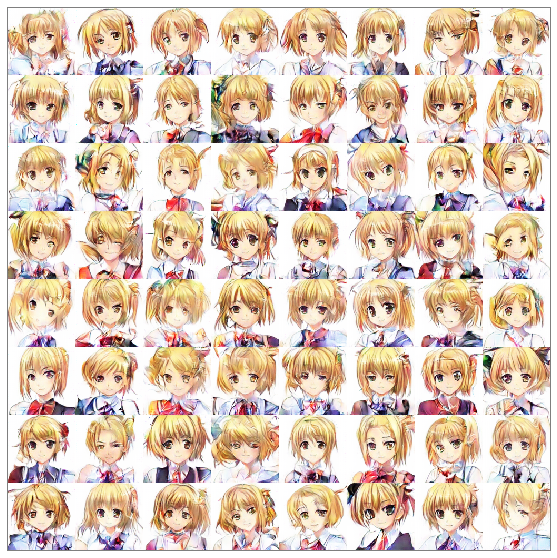

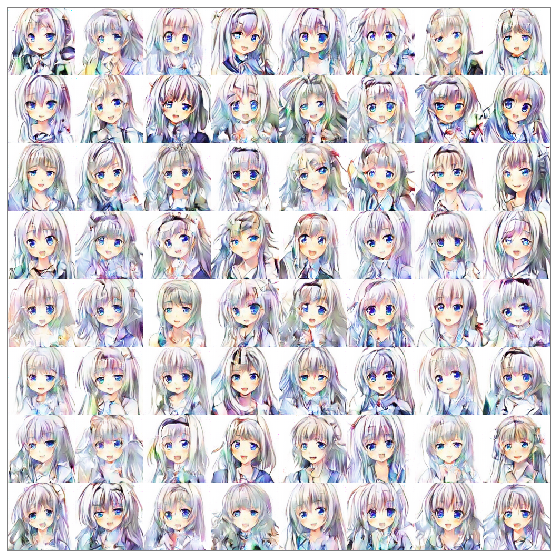

In [21]:
# 生成指定标签的样本
all_tags = [
    'blonde hair', 'brown hair', 'black hair', 'blue hair', 'pink hair',
    'purple hair', 'green hair', 'red hair', 'silver hair', 'white hair',
    'orange hair', 'aqua hair', 'grey hair', 'long hair', 'short hair',
    'twintails', 'drill hair', 'ponytail', 'blue eyes', 'red eyes',
    'brown eyes', 'green eyes', 'purple eyes', 'yellow eyes', 'pink eyes',
    'aqua eyes', 'black eyes', 'orange eyes', 'blush', 'smile', 'open mouth',
    'hat', 'ribbon', 'glasses'
]

for i, tags in enumerate(
    [['blonde hair', 'short hair', 'smile', 'ribbon', 'brown eyes'],
     ['silver hair', 'long hair', 'blush', 'smile', 'open mouth', 'blue eyes']]):
    z_samples = np.random.uniform(-1.0, 1.0,
                                  [batch_size, z_dim]).astype(np.float32)
    y_samples = np.zeros([1, LABEL])
    
    for tag in tags:
        y_samples[0, all_tags.index(tag)] = 1
    
    y_samples = np.repeat(y_samples, batch_size, 0)
    
    gen_imgs = sess.run(g,
                        feed_dict={
                            noise: z_samples,
                            noise_y: y_samples,
                            is_training: False
                        })
    gen_imgs = (gen_imgs + 1) / 2
    imgs = [img[:, :, :] for img in gen_imgs]
    gen_imgs = montage(imgs)
    gen_imgs = np.clip(gen_imgs, 0, 1)
    
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(gen_imgs)
    
    imsave('%d_test_2.jpg' % (i + 2), gen_imgs)

#### 固定噪音(noise)随机标签(noise_y)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


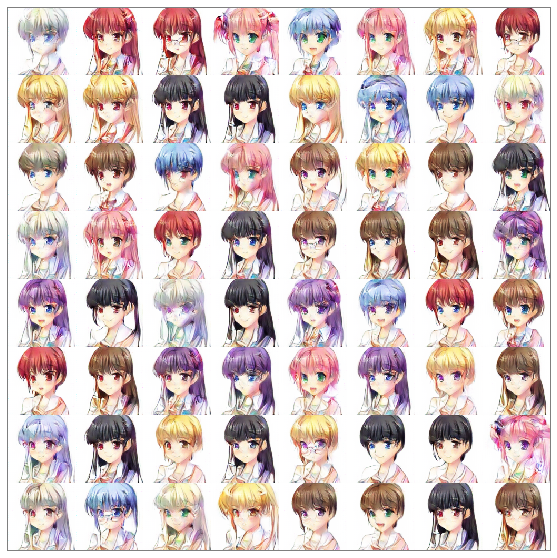

In [22]:
z_samples = np.random.uniform(-1.0, 1.0, [1, z_dim]).astype(np.float32)
z_samples = np.repeat(z_samples, batch_size, 0)
y_samples = get_random_tags()

gen_imgs = sess.run(g, feed_dict={noise: z_samples, noise_y: y_samples, is_training: False})

gen_imgs = (gen_imgs + 1) / 2
imgs = [img[:, :, :] for img in gen_imgs]
gen_imgs = montage(imgs)
gen_imgs = np.clip(gen_imgs, 0, 1)

plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(gen_imgs)

imsave('test_3.jpg', gen_imgs)